In [3]:
import cv2
import numpy as np
import sys
import keyboard
import time
import os
import glob
import matplotlib.pyplot as plt

In [4]:
class Camera:
    def __init__(self, name):
        self.name = name
        self.camera_params = []
        self.camera_matrix = []
        self.roi = ()
        self.dist = []
        self.objpoints = []
        self.imgpoints = []

    def calibrate(self):
        """
        Calibrate a camera using calibration images of a chessboard of a chosen size.
        """
        current_directory = os.getcwd()

        # size of chessboard (L x W) - inner chessboard
        size_of_target = (7 * 5, 3)

        # termination criteria
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

        # prepare object points, like (0,0,0), (2,0,0) ..., (6,5,0)
        objp = np.zeros(size_of_target, np.float32)
        objp[:, :2] = np.mgrid[0:7, 0:5].T.reshape(-1, 2)

        objp = objp*30

        # arrays to store object points and image points from all the images
        objpoints = []                                      # 3d points in real space
        imgpoints = []                                      # 2d points in real space

        # grabbing all the calibration images for the camera
        images = glob.glob(str(current_directory) + '/calibration_images/cal_' + self.name + '_img_*.png')

        # Check if images exist
        if not images:
            print(f"Error: No calibration images found for '{self.name}' camera.")
            return

        #
        for fname in images:

            img = cv2.imread(fname)                         # reading in image N
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)    # converting it to grayscale

            # find the chess board corners
            ret, corners = cv2.findChessboardCorners(gray, (7, 5), None)

            # if found, add object points, image points (after refining them)
            if ret == True:
                print(f"Processing {fname}...")
                objpoints.append(objp)

                corners2 = cv2.cornerSubPix(gray, corners, (9, 9), (-1, -1), criteria)
                imgpoints.append(corners2)

                # draw and display corners
                cv2.drawChessboardCorners(img, (7, 5), corners2, ret)
                cv2.imshow('img', img)
                cv2.waitKey(500)
            else:
                print(f"Chessboard not detected in {fname}.")

        cv2.destroyAllWindows()

        h, w = gray.shape[:2]
        self.camera_params = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None,
                                                 None)  # ret, mtx, dist, rvecs, tvecs
        self.camera_matrix, self.roi = cv2.getOptimalNewCameraMatrix(self.camera_params[1], self.camera_params[2],
                                                                     (w, h), 1, (w, h))
        self.objpoints = objpoints
        self.imgpoints = imgpoints

    def undistort(self, img):
        h, w = img.shape[:2]

        undistorted = cv2.undistort(img, self.camera_params[1], self.camera_params[2], None, self.camera_matrix)

        x, y, w, h = self.roi
        undistorted = undistorted[y:y + h, x:x + w]
        # **Optional: Resize back to original**
        #undistorted = cv2.resize(undistorted, (w, h))
        
        cv2.imshow('Original Image', img)
        cv2.imshow('Undistorted Image', undistorted)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

In [5]:
def stereo_rectify():
    flags = 0
    flags |= cv2.CALIB_FIX_INTRINSIC
    # Here we fix the intrinsic camara matrixes so that only Rot, Trns, Emat and Fmat are calculated.
    # Hence intrinsic parameters are the same
    gray = np.zeros((240, 320))
    criteria_stereo = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    # This step is performed to transformation between the two cameras and calculate Essential and Fundamental matrix
    retS, new_mtxL, distL, new_mtxR, distR, Rot, Trns, Emat, Fmat = cv2.stereoCalibrate(left_camera.objpoints,
                                                                                        left_camera.imgpoints,
                                                                                        right_camera.imgpoints,
                                                                                        left_camera.camera_matrix,
                                                                                        left_camera.camera_params[2],
                                                                                        right_camera.camera_matrix,
                                                                                        right_camera.camera_params[2],
                                                                                        gray.shape[::-1],
                                                                                        criteria_stereo,
                                                                                        flags)

    rectify_scale = 1
    rect_l, rect_r, proj_mat_l, proj_mat_r, Q, roiL, roiR = cv2.stereoRectify(new_mtxL,
                                                                              distL,
                                                                              new_mtxR,
                                                                              distR,
                                                                              gray.shape[::-1],
                                                                              Rot,
                                                                              Trns,
                                                                              rectify_scale, (0, 0))

    Left_Stereo_Map = cv2.initUndistortRectifyMap(new_mtxL, distL, rect_l, proj_mat_l,
                                                  gray.shape[::-1], cv2.CV_16SC2)
    Right_Stereo_Map = cv2.initUndistortRectifyMap(new_mtxR, distR, rect_r, proj_mat_r,
                                                   gray.shape[::-1], cv2.CV_16SC2)

    print("Saving parameters ......")
    cv_file = cv2.FileStorage("improved_params2.xml", cv2.FILE_STORAGE_WRITE)
    cv_file.write("Left_Stereo_Map_x", Left_Stereo_Map[0])
    cv_file.write("Left_Stereo_Map_y", Left_Stereo_Map[1])
    cv_file.write("Right_Stereo_Map_x", Right_Stereo_Map[0])
    cv_file.write("Right_Stereo_Map_y", Right_Stereo_Map[1])
    cv_file.release()
    print("Done")


    imgL = cv2.imread(r'calibration_images/cal_left_img_1.png')
    imgR = cv2.imread(r'calibration_images/cal_right_img_1.png')

    cv2.imshow("Left image before rectification", imgL)
    cv2.imshow("Right image before rectification", imgR)

    Left_nice = cv2.remap(imgL, Left_Stereo_Map[0], Left_Stereo_Map[1], cv2.INTER_LANCZOS4, cv2.BORDER_CONSTANT, 0)
    Right_nice = cv2.remap(imgR, Right_Stereo_Map[0], Right_Stereo_Map[1], cv2.INTER_LANCZOS4, cv2.BORDER_CONSTANT, 0)

    cv2.imshow("Left image after rectification", Left_nice)
    cv2.imshow("Right image after rectification", Right_nice)
    cv2.waitKey(0)

    out = Right_nice.copy()
    out[:, :, 0] = Right_nice[:, :, 0]
    out[:, :, 1] = Right_nice[:, :, 1]
    out[:, :, 2] = Left_nice[:, :, 2]

    cv2.imshow("Output image", out)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


In [6]:
def view_rectified_image():
    pass
# ret, mtx, dist, rvecs, tvecs = calibrate()

In [7]:
def take_images():
    current_directory = os.getcwd()
    new_directory = os.path.join(current_directory, r'calibration_images')
    if not os.path.exists(new_directory):
        os.makedirs(new_directory)

    s = 1
    if len(sys.argv) > 1:
        s = sys.argv[1]
    source = cv2.VideoCapture(s)


    i = 1
    while cv2.waitKey(1) != 27:  # Escape to exit
        has_frame, frame = source.read()
        frame = cv2.flip(frame, 0)

        if keyboard.is_pressed('s'):  # wait for 's' key to save images
            left_img = frame[:, :int(frame.shape[1] / 2), :]
            right_img = frame[:, int(frame.shape[1] / 2):, :]
            cv2.imwrite(str(new_directory) + '/cal_right_img_' + str(i) + '.png', right_img)
            cv2.imwrite(str(new_directory) + '/cal_left_img_' + str(i) + '.png', left_img)

            i += 1
            time.sleep(.1)  # debounce key press

        cv2.imshow('Camera', frame)
    source.release()
    cv2.destroyAllWindows()


In [1]:
take_images()

NameError: name 'take_images' is not defined

In [24]:
left_camera = Camera('left')
right_camera = Camera('right') 

In [25]:
left_camera.calibrate()
right_camera.calibrate()

Processing C:\Users\rayce\OneDrive\Documents\GitHub\HindSight\python\hindsight/calibration_images\cal_left_img_1.png...
Processing C:\Users\rayce\OneDrive\Documents\GitHub\HindSight\python\hindsight/calibration_images\cal_left_img_10.png...
Processing C:\Users\rayce\OneDrive\Documents\GitHub\HindSight\python\hindsight/calibration_images\cal_left_img_11.png...
Processing C:\Users\rayce\OneDrive\Documents\GitHub\HindSight\python\hindsight/calibration_images\cal_left_img_12.png...
Processing C:\Users\rayce\OneDrive\Documents\GitHub\HindSight\python\hindsight/calibration_images\cal_left_img_13.png...
Processing C:\Users\rayce\OneDrive\Documents\GitHub\HindSight\python\hindsight/calibration_images\cal_left_img_14.png...
Processing C:\Users\rayce\OneDrive\Documents\GitHub\HindSight\python\hindsight/calibration_images\cal_left_img_15.png...
Processing C:\Users\rayce\OneDrive\Documents\GitHub\HindSight\python\hindsight/calibration_images\cal_left_img_16.png...
Processing C:\Users\rayce\OneDriv

In [16]:
imgL = cv2.imread(r'calibration_images/cal_left_img_1.png')
print(imgL.shape)
left_camera.undistort(imgL)
left_camera.roi

(240, 320, 3)


(0, 0, 319, 239)

In [17]:
imgR = cv2.imread(r'calibration_images/cal_right_img_1.png')
right_camera.undistort(imgR)
right_camera.roi

(0, 0, 319, 239)

In [27]:
# Camera parameters to undistort and rectify images
cv_file = cv2.FileStorage()
cv_file.open('improved_params2.xml', cv2.FileStorage_READ)

stereoMapL_x = cv_file.getNode('Left_Stereo_Map_x').mat()
stereoMapL_y = cv_file.getNode('Left_Stereo_Map_y').mat()
stereoMapR_x = cv_file.getNode('Right_Stereo_Map_x').mat()
stereoMapR_y = cv_file.getNode('Right_Stereo_Map_y').mat()

frameL = cv2.imread(r'calibration_images/cal_left_img_1.png')
frameR = cv2.imread(r'calibration_images/cal_right_img_1.png')

def undistortRectify(frameR, frameL):

    # Undistort and rectify images
    undistortedL= cv2.remap(frameL, stereoMapL_x, stereoMapL_y, cv2.INTER_LANCZOS4, cv2.BORDER_CONSTANT, 0)
    undistortedR= cv2.remap(frameR, stereoMapR_x, stereoMapR_y, cv2.INTER_LANCZOS4, cv2.BORDER_CONSTANT, 0)


    return undistortedR, undistortedL

undistortedR, undistortedL = undistortRectify(frameL, frameR)

cv2.imshow('left', undistortedL)
cv2.imshow('right', undistortedR)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [26]:
stereo_rectify()

Saving parameters ......
Done


In [16]:
print(stereoMapL_x)

None


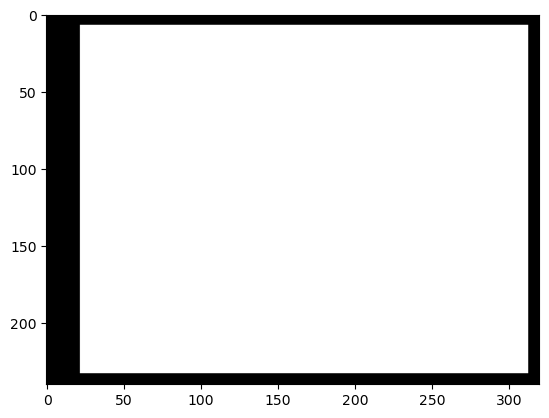

In [4]:
imgL = cv2.imread(r'calibration_images/cal_left_img_1.png', cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread(r'calibration_images/cal_left_img_1.png', cv2.IMREAD_GRAYSCALE)
 
stereo = cv2.StereoBM.create(numDisparities=16, blockSize=15)
disparity = stereo.compute(imgL,imgR)
plt.imshow(disparity,'gray')
plt.show()

In [5]:
imgL = cv2.imread(r'calibration_images/cal_left_img_1.png', cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread(r'calibration_images/cal_right_img_1.png', cv2.IMREAD_GRAYSCALE)
 
# Setting parameters for StereoSGBM algorithm
minDisparity = 0;
numDisparities = 64;
blockSize = 8;
disp12MaxDiff = 1;
uniquenessRatio = 10;
speckleWindowSize = 10;
speckleRange = 8;
 
# Creating an object of StereoSGBM algorithm
stereo = cv2.StereoSGBM_create(minDisparity = minDisparity,
        numDisparities = numDisparities,
        blockSize = blockSize,
        disp12MaxDiff = disp12MaxDiff,
        uniquenessRatio = uniquenessRatio,
        speckleWindowSize = speckleWindowSize,
        speckleRange = speckleRange
    )
 
# Calculating disparith using the StereoSGBM algorithm
disp = stereo.compute(imgL, imgR).astype(np.float32)
disp = cv2.normalize(disp,0,255,cv2.NORM_MINMAX)
 
# Displaying the disparity map
cv2.imshow("disparity",disp)
cv2.waitKey(0)

27